## Imports

In [118]:
import os
import random
from collections import defaultdict
from string import ascii_letters
from matplotlib import pyplot as plt
import torch
from torch import nn
from unidecode import unidecode
from sklearn.model_selection import train_test_split

## Data Preparation

In [119]:
# Setting the seed to the same value for each run is essential seems it allows to developers to compare results of the algorythm
_ = torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                      
data_dir = "./data/names"


# Mapping from language labels to PyTorch tensors, where each tensor represents a language label using its index in the list of file names
lang2label = {
    file_name.split(".")[0]: torch.tensor([i], dtype=torch.long)
    for i, file_name in enumerate(os.listdir(data_dir))
}

# print(lang2label)
num_langs = len(lang2label)

## Data Preprocessing 

In [120]:
# Mapping each character to its corresponding index
char2idx = {letter: i for i, letter in enumerate(ascii_letters + " .,:;-'")}

num_letters = len(char2idx)

def name2tensor(n):
    tensor = torch.zeros(len(n), 1, num_letters)
    for i, c in enumerate(n):
        tensor[i][0][char2idx[c]] = 1
    return tensor

## Data Creation

In [121]:
tensor_names = []
target_langs = []
languages = []


# Extract names from files and assign languages to them
for file in os.listdir(data_dir):
    with open(os.path.join(data_dir, file), encoding="utf8") as f:
        lang = file.split(".")[0]
        names = [unidecode(line.rstrip()) for line in f]
        for name in names:
            try:
                tensor_names.append(name2tensor(name))
                target_langs.append(lang2label[lang])
            except KeyError:
                pass


# Prepare training and testing sets
train_idx, test_idx = train_test_split(
    range(len(target_langs)), 
    test_size=0.1, 
    shuffle=True, 
    stratify=target_langs
)

train_dataset = [
    (tensor_names[i], target_langs[i])
    for i in train_idx
]

test_dataset = [
    (tensor_names[i], target_langs[i])
    for i in test_idx
]

print(f"Train: {len(train_dataset)}")
print(f"Test: {len(test_dataset)}")


Train: 18063
Test: 2007


## Dataset Plot

Representation of the dataset that may help explain why certain languages are chosen more often than others

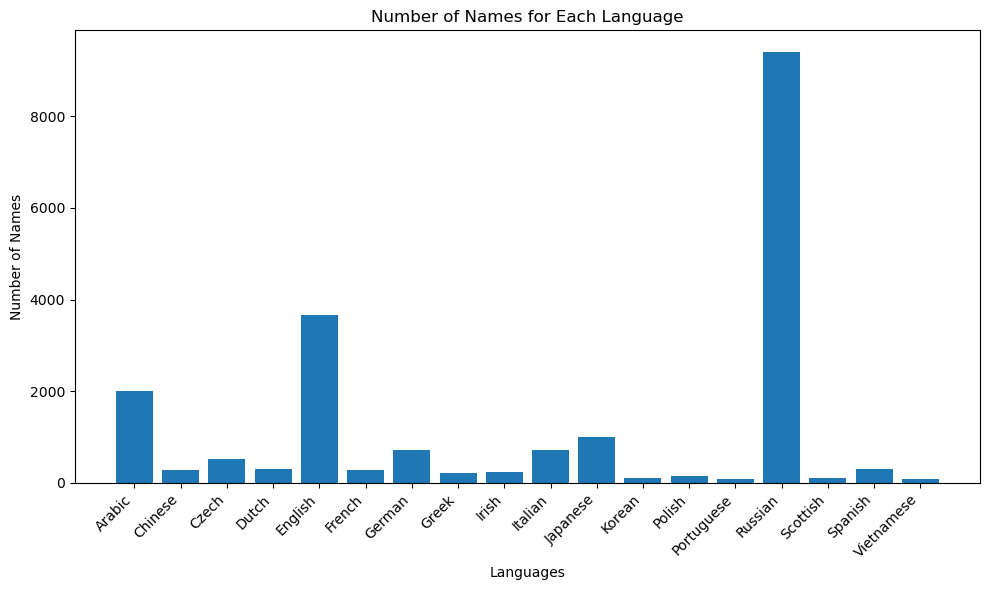

In [122]:

# Count the occurrences of each language
count = defaultdict(int)
for lang in target_langs:
    count[lang] += 1

# Extract languages and counts
languages = list(["Arabic", "Chinese", "Czech", "Dutch", "English", "French", "German", "Greek", "Irish", "Italian", "Japanese","Korean", "Polish", "Portuguese", "Russian", "Scottish", "Spanish", "Vietnamese"])
counts = list(count.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(languages, counts)
plt.xlabel('Languages')
plt.ylabel('Number of Names')
plt.title('Number of Names for Each Language')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

## Model

In [123]:
# Model Definition
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden
        self.in2hidden = nn.Linear(input_size + hidden, hidden)
        self.in2output = nn.Linear(input_size + hidden, output_size)
    
    def forward(self, x, hidden_current):
        combined = torch.cat((x, hidden_current), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output_forward = self.in2output(combined)
        return output_forward, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))
    

# Number of hidden layers
hidden_size = 256
# Learning rate for the optimizer
learning_rate = 0.001

# Model Creation 
model = MyRNN(num_letters, hidden_size, num_langs)
# Loss Function Definition
criterion = nn.CrossEntropyLoss()
# Optimizer Definition
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## Training Model

In [124]:
num_epochs = 3
print_interval = 3000

# Backpropagation
for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    for i, (name, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        for char in name:
            result, hidden_state = model(char, hidden_state)
        loss = criterion(result, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )

Epoch [1/1], Step [3000/18063], Loss: 0.0220
Epoch [1/1], Step [6000/18063], Loss: 1.7194
Epoch [1/1], Step [9000/18063], Loss: 2.2227
Epoch [1/1], Step [12000/18063], Loss: 0.2549
Epoch [1/1], Step [15000/18063], Loss: 0.0036
Epoch [1/1], Step [18000/18063], Loss: 0.7166


## Model Result

In [125]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

# Testing model on test data set
with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            output, hidden_state = model(char, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")



Accuracy: 67.8625%


## Model Test Function

In [126]:
label2lang = {label.item(): lang for lang, label in lang2label.items()}

def my_rnn_predict(name_input):
    model.eval()
    tensor_name = name2tensor(name_input)
    with torch.no_grad():
        hidden = model.init_hidden()
        for c in tensor_name:
            result, hidden = model(c, hidden)
        _, prediction = torch.max(result, dim=1)
    model.train()    
    return label2lang[prediction.item()]


## Testing

In [127]:
print(my_rnn_predict("Saruman"))

print(my_rnn_predict("Fabian"))

print(my_rnn_predict("Yuan"))

print(my_rnn_predict("Edmund"))


Arabic
Russian
English
English
